# W281 Final Project: Intel Image Classification Model #

### Libraries

In [34]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import gc

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import io, color
from skimage.color import rgb2gray, rgb2hsv
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Flatten, GlobalAveragePooling2D

SyntaxError: invalid syntax (1416947810.py, line 35)

### Data Load

In [2]:
def load_data(datasets):
    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")
        i = 0
        for folder in os.listdir(dataset):
            label = i # Converting word labels to int (i.e. buildings = 0)
            i = i+1
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).resize((150, 150))
                images.append(image)
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [3]:
datasets = [r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train", 
        r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test"]

train_path, test_path = datasets

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data(datasets)

Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train...


Processing street: 100%|██████████| 2382/2382 [00:02<00:00, 927.60it/s] 


Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test...


Processing Street: 100%|██████████| 501/501 [00:00<00:00, 594.93it/s]


In [5]:
# Reshape images into 2D array (flatten each image)
# Flatten the data for Random Forest & SVM
train_images_flat = train_images.reshape(len(train_images), -1)
test_images_flat = test_images.reshape(len(test_images), -1)

### Clean Data

In [6]:
# Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

### Feature Extraction

#### HSV Feature Extraction

In [7]:
def create_hsv_feature_vectors(images, bins=32):
    all_hsv_features = []
    
    for img in tqdm(images):
        # Convert RGB to HSV
        hsv_img = color.rgb2hsv(img)
        
        hsv_features = hsv_img.reshape(-1)  # Flattens to 1D array
        
        all_hsv_features.append(hsv_features)
    
    # Convert to numpy array
    feature_vectors = np.array(all_hsv_features)
    
    return feature_vectors

In [8]:
# Use it on your datasets
train_hsv_features = create_hsv_feature_vectors(train_images)
test_hsv_features = create_hsv_feature_vectors(test_images)

100%|██████████| 3000/3000 [00:29<00:00, 101.94it/s]


#### HOG Feature Extraction

In [9]:
def create_hog_feature_vectors(images):
    
    # Initialize list to store HOG features for each image
    all_hog_features = []
    
    # Process each image individually
    for img in tqdm(images):

        # Convert single image to grayscale
        gray_img = color.rgb2gray(img)
        
        # Calculate HOG features for image
        hog_features, _= hog(
            gray_img,
            orientations=9,  # default testue, keeping this
            pixels_per_cell=(16, 16),  # increased from 8x8 to 16x16
            cells_per_block=(2, 2),  # keeping this the same
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        
        all_hog_features.append(hog_features)
    
    # Convert list of features to numpy array
    feature_vectors = np.array(all_hog_features)
    
    return feature_vectors

In [10]:
# Create feature vectors for both training and test sets
train_hog_features = create_hog_feature_vectors(train_images)
test_hog_features = create_hog_feature_vectors(test_images)

100%|██████████| 3000/3000 [00:53<00:00, 55.86it/s]


In [11]:
train_hog_features = train_images.reshape(len(train_hog_features), -1)
test_hog_features = test_images.reshape(len(test_hog_features), -1)

#### ResNet

In [12]:
# Function to extract features using ResNet50
def extract_resnet_features(images):
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(150, 150, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    features = model.predict(images, batch_size=32, verbose=1)
    return features

In [13]:
# Reduce dataset size if necessary (optional)
# To reduce computation time, you can sample a subset of data
# For example, use 2000 samples
sample_size = 2000
train_indices = np.random.choice(len(train_hog_features), sample_size, replace=False)
test_indices = np.random.choice(len(test_hog_features), int(sample_size * 0.2), replace=False)


In [14]:
print("\n--- Extracting ResNet Features ---")
train_resnet_features = extract_resnet_features(train_images)
test_resnet_features = extract_resnet_features(test_images)


--- Extracting ResNet Features ---
439/439 ━━━━━━━━━━━━━━━━━━━━ 436s 980ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 65s 617ms/step


In [ ]:
# train_resnet_sample = train_resnet[train_indices]
# test_resnet_sample = test_resnet[test_indices]

In [ ]:
# print("\n--- Processing ResNet Features ---")
# # ResNet features are already of lower dimension, you may skip PCA or apply minimal reduction
# train_resnet_pca, test_resnet_pca = process_features(train_resnet_sample, test_resnet_sample, n_components=128)


## Models

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

In [55]:
# Model classifaction results
def classification_results(X_val_perc, y_val_perc, perceptron):
    perceptron_pred = perceptron.predict(X_val_perc)

    print("\nClassification Report:\n", classification_report(y_val_perc, perceptron_pred, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

    perceptron_cm = confusion_matrix(y_val_perc, perceptron_pred)

    perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
    perceptron_disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {perceptron}")
    plt.show()

### Perceptron

In [27]:
from sklearn.linear_model import Perceptron

In [15]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [25]:
def train_perceptron(X_train, y_train, max_iter=2000):
    perceptron = Perceptron(max_iter=max_iter, tol=1e-3, random_state=0)
    perceptron.fit(X_train, y_train)
    return perceptron

##### Original Images

In [26]:
# 24 m 49.5 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)

In [ ]:
# Validation
# 14.7 s
classification_results(X_val_perc, y_val_perc, perceptron)


In [ ]:
# Test
# 7.5 s
classification_results(test_images_flat, test_labels, perceptron)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HSV

In [30]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [31]:
# 13 m 35.1 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)

In [ ]:
# Validation
# 10.8 s
classification_results(X_val_perc, y_val_perc, perceptron)

In [ ]:
# Test
# 3.4 s
classification_results(test_hsv_features, test_labels, perceptron)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HOG

In [ ]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [35]:
# 24 m 1.6 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)

In [ ]:
# Validation
# 11.3 s
classification_results(X_val_perc, y_val_perc, perceptron)

In [ ]:
# Test
# 3.5 s
classification_results(test_hog_features, test_labels, perceptron)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [83]:
def train_logistic_regression(X_train, y_train, max_iter=1000):
    lr = LogisticRegression(#multi_class='multinomial', 
                           max_iter=max_iter,
                           random_state=0)
    lr.fit(X_train, y_train)
    return lr


##### Original Images

In [84]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 29 m 16.4 s
# 28 m 12.1 s
# 31 m 18.1 s 
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

In [ ]:
# Validation
# 3.5 s
classification_results(X_val_logreg, y_val_logreg, clf)

In [ ]:
# Test
# 3.5 s
classification_results(test_images_flat, test_labels, clf)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HSV

In [89]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 55 m 34.5 s
# 40 m 34.7 s
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

In [ ]:
# Validation
# 3.5 s
classification_results(X_val_logreg, y_val_logreg, clf)

In [ ]:
# Test
# 3.5 s
classification_results(test_hsv_features, test_labels, clf)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HOG

In [17]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 30 m 55.6 s
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

In [ ]:
# Validation
# 26.3 s
classification_results(X_val_logreg, y_val_logreg, clf)

In [ ]:
# Test
# 21.2 s
classification_results(test_hog_features, test_labels, clf)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

### SVM

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

##### HSV - PCA

In [ ]:
train_hsv_features = train_hsv_features.astype('float32')
test_hsv_features = test_hsv_features.astype('float32')

In [153]:
from sklearn.random_projection import SparseRandomProjection

transformer = SparseRandomProjection(n_components=1000)
transformer.fit(train_hsv_features[:1000])  # Fit on subset

# Transform in batches
batch_size = 1000
train_reduced = np.zeros((train_hsv_features.shape[0], 1000))
test_reduced = np.zeros((test_hsv_features.shape[0], 1000))

for i in range(0, len(train_hsv_features), batch_size):
    train_reduced[i:i + batch_size] = transformer.transform(train_hsv_features[i:i + batch_size])

for i in range(0, len(test_hsv_features), batch_size):
    test_reduced[i:i + batch_size] = transformer.transform(test_hsv_features[i:i + batch_size])

In [154]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(train_reduced)
X_test_pca = pca.transform(test_reduced)

In [155]:
# HOG - PCA
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    X_train_pca,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [157]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_ml)
X_val_pca = pca.transform(X_val_ml)  # Transform validation data using fitted PCA
X_test_pca = pca.transform(X_test_pca)  # Transform test data using fitted PCA

In [158]:
X_train_pca = scaler.fit_transform(X_train_pca)
X_val_pca = scaler.transform(X_val_pca)
X_test_pca = scaler.fit_transform(X_test_pca)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Train on PCA-transformed training data
print("Starting Grid Search Training...")
grid_search.fit(X_train_pca, y_train_ml)

print("\n=== Grid Search Results ===")
print(f"\nBest score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Display all parameter combinations and their scores
print("\nAll Parameter Combinations and Scores:")
results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(len(results_df)):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    std_score = results_df.loc[i, 'std_test_score']
    print(f"\nParameters: {params}")
    print(f"Mean CV Score: {mean_score:.4f} (+/- {std_score:.4f})")
    

best_model = grid_search.best_estimator_

In [ ]:

val_predictions = best_model.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val_ml, val_predictions))
print("\nClassification Report:\n", classification_report(y_val_ml, val_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(y_val_ml, val_predictions)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

In [ ]:

test_predictions = best_model.predict(X_test_pca)
print("Validation accuracy:", accuracy_score(test_labels, test_predictions))
print("\nClassification Report:\n", classification_report(test_labels, test_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(test_labels, test_predictions)

perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
perceptron_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Perceptron")
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

#### HOG - PCA

In [163]:
train_hog_features = train_hog_features.astype('float32')
test_hog_features = test_hog_features.astype('float32')

In [164]:
from sklearn.random_projection import SparseRandomProjection

transformer = SparseRandomProjection(n_components=1000)
transformer.fit(train_hog_features[:1000])  # Fit on subset

# Transform in batches
batch_size = 1000
train_reduced = np.zeros((train_hog_features.shape[0], 1000))
test_reduced = np.zeros((test_hog_features.shape[0], 1000))

for i in range(0, len(train_hog_features), batch_size):
    train_reduced[i:i + batch_size] = transformer.transform(train_hog_features[i:i + batch_size])

for i in range(0, len(test_hog_features), batch_size):
    test_reduced[i:i + batch_size] = transformer.transform(test_hog_features[i:i + batch_size])


In [165]:
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(train_reduced)
X_test_pca = pca.transform(test_reduced)

In [166]:
X_train_pca, X_val_pca, y_train_ml, y_val_ml = train_test_split(
    X_train_pca, 
    train_labels, 
    test_size=0.2, 
    random_state=42
)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Train on PCA-transformed training data
print("Starting Grid Search Training...")
grid_search.fit(X_train_pca, y_train_ml)

print("\n=== Grid Search Results ===")
print(f"\nBest score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Display all parameter combinations and their scores
print("\nAll Parameter Combinations and Scores:")
results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(len(results_df)):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    std_score = results_df.loc[i, 'std_test_score']
    print(f"\nParameters: {params}")
    print(f"Mean CV Score: {mean_score:.4f} (+/- {std_score:.4f})")
    

best_model = grid_search.best_estimator_

In [ ]:

val_predictions = best_model.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val_ml, val_predictions))
print("\nClassification Report:\n", classification_report(y_val_ml, val_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(y_val_ml, val_predictions)

SVM_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
SVM_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show()

In [ ]:

test_predictions = best_model.predict(X_test_pca)
print("Test accuracy:", accuracy_score(test_labels, test_predictions))
print("\nClassification Report:\n", classification_report(test_labels, test_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(test_labels, test_predictions)

svm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
svm_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show() 

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

#### Resnet - PCA

In [17]:
train_resnet = train_resnet.astype('float32')
test_resnet = test_resnet.astype('float32')

In [ ]:
from sklearn.random_projection import SparseRandomProjection

# Initialize transformer and fit
transformer = SparseRandomProjection(n_components=1000)
transformer.fit(train_resnet[:1000])

# Set up batch processing
batch_size = 1000
train_reduced = np.zeros((train_resnet.shape[0], 1000))
test_reduced = np.zeros((test_resnet.shape[0], 1000))

# Transform training data in batches
for i in range(0, len(train_resnet), batch_size):
   train_reduced[i:i + batch_size] = transformer.transform(train_resnet[i:i + batch_size])

# Transform test data in batches  
for i in range(0, len(test_resnet), batch_size):
   test_reduced[i:i + batch_size] = transformer.transform(test_resnet[i:i + batch_size])

In [23]:
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(train_reduced)
X_test_pca = pca.transform(test_reduced)

In [24]:
X_train_pca, X_val_pca, y_train_ml, y_val_ml = train_test_split(
    X_train_pca, 
    train_labels, 
    test_size=0.2, 
    random_state=42
)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Train on PCA-transformed training data
print("Starting Grid Search Training...")
grid_search.fit(X_train_pca, y_train_ml)

print("\n=== Grid Search Results ===")
print(f"\nBest score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Display all parameter combinations and their scores
print("\nAll Parameter Combinations and Scores:")
results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(len(results_df)):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    std_score = results_df.loc[i, 'std_test_score']
    print(f"\nParameters: {params}")
    print(f"Mean CV Score: {mean_score:.4f} (+/- {std_score:.4f})")
    

best_model = grid_search.best_estimator_

In [ ]:

val_predictions = best_model.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val_ml, val_predictions))
print("\nClassification Report:\n", classification_report(y_val_ml, val_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(y_val_ml, val_predictions)

svm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
svm_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show()

In [ ]:

test_predictions = best_model.predict(X_test_pca)
print("Test accuracy:", accuracy_score(test_labels, test_predictions))
print("\nClassification Report:\n", classification_report(test_labels, test_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
svm_cm = confusion_matrix(test_labels, test_predictions)

svm_disp = ConfusionMatrixDisplay(confusion_matrix = svm_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
svm_disp.plot(cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.show() 

### CNN

##### Naive

In [21]:
# Convert labels to one-hot encoding for CNN/ResNet
num_classes = len(np.unique(train_labels))
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes)

In [ ]:
# Create train/validation split for CNN/ResNet
X_train, X_val, y_train, y_val = train_test_split(
    train_images, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [ ]:
# Define a CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the CNN model
cnn_model = create_cnn_model((150, 150, 3), num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN Model
cnn_history = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Evaluate the CNN Model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_images, test_labels_onehot)
print(f"CNN Model Accuracy: {cnn_accuracy * 100:.2f}%")

In [ ]:
# Make predictions
y_pred = cnn_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HSV

In [38]:
# Create train/validation split for CNN/ResNet
X_train, X_val, y_train, y_val = train_test_split(
    train_hsv_features, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [ ]:
print(X_train.shape)
print(X_val.shape)

In [40]:
X_train = X_train.reshape(-1, 150, 150, 3)
X_val = X_val.reshape(-1, 150, 150, 3)
test_images = test_images.reshape(-1, 150, 150, 3)

In [ ]:
# Define a CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the CNN model
cnn_model = create_cnn_model((150, 150, 3), num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN Model
cnn_history = cnn_model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

In [ ]:
test_hsv_features_reshaped = test_hsv_features.reshape(-1, 150, 150, 3)

# Make predictions
y_pred = cnn_model.predict(test_hsv_features_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

##### HOG

In [45]:
# Create train/validation split for CNN/ResNet
X_train, X_val, y_train, y_val = train_test_split(
    train_hog_features, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [46]:
X_train = X_train.reshape(-1, 150, 150, 3)
X_val = X_val.reshape(-1, 150, 150, 3)
test_images = test_images.reshape(-1, 150, 150, 3)

In [ ]:
# Define a CNN Model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Compile the CNN model
cnn_model = create_cnn_model((150, 150, 3), num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN Model
cnn_history = cnn_model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

In [ ]:
test_hog_features_reshaped = test_hog_features.reshape(-1, 150, 150, 3)

# Make predictions
y_pred = cnn_model.predict(test_hog_features_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### Multimodal

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, Add

In [17]:
# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        img_gray = rgb2gray(img)
        features = hog(img_gray, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

# Function to extract HSV histogram features
def extract_hsv_features(images):
    hsv_features = []
    for img in tqdm(images, desc="Extracting HSV features"):
        img_hsv = rgb2hsv(img)
        h_hist, _ = np.histogram(img_hsv[:, :, 0], bins=50, range=(0, 1))
        s_hist, _ = np.histogram(img_hsv[:, :, 1], bins=50, range=(0, 1))
        v_hist, _ = np.histogram(img_hsv[:, :, 2], bins=50, range=(0, 1))
        features = np.concatenate([h_hist, s_hist, v_hist])
        hsv_features.append(features)
    return np.array(hsv_features)

# Function to extract features using ResNet50
def extract_resnet_features(images):
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(150, 150, 3))
    model = Model(inputs=base_model.input, outputs=base_model.output)
    features = model.predict(images, batch_size=32, verbose=1)
    return features

In [18]:
# Prepare a function to process features, apply PCA, and scale
def process_features(train_feat, test_feat, n_components=100):
    scaler = StandardScaler()
    pca = PCA(n_components=n_components)

    # Scale features
    train_feat_scaled = scaler.fit_transform(train_feat)
    test_feat_scaled = scaler.transform(test_feat)

    # Apply PCA
    train_feat_pca = pca.fit_transform(train_feat_scaled)
    test_feat_pca = pca.transform(test_feat_scaled)

    return train_feat_pca, test_feat_pca

In [19]:
# Combine Features into a Single Matrix
def combine_features(hog_features, hsv_features, resnet_features):
    return np.hstack((hog_features, hsv_features, resnet_features))

# Extract Features (as done earlier)
print("\n--- Extracting Features ---")
train_hog = extract_hog_features(train_images)
test_hog = extract_hog_features(test_images)

train_hsv = extract_hsv_features(train_images)
test_hsv = extract_hsv_features(test_images)

train_resnet = extract_resnet_features(train_images)
test_resnet = extract_resnet_features(test_images)

# Optional: Apply PCA to reduce dimensions of each feature set
train_hog_pca, test_hog_pca = process_features(train_hog, test_hog, n_components=100)
train_hsv_pca, test_hsv_pca = process_features(train_hsv, test_hsv, n_components=50)
train_resnet_pca, test_resnet_pca = process_features(train_resnet, test_resnet, n_components=128)

# Combine Features
print("\n--- Combining Features PCA---")
train_combined_pca = combine_features(train_hog_pca, train_hsv_pca, train_resnet_pca)
test_combined_pca = combine_features(test_hog_pca, test_hsv_pca, test_resnet_pca)

# Combine Features
print("\n--- Combining Features ---")
train_combined = combine_features(train_hog, train_hsv, train_resnet)
test_combined = combine_features(test_hog, test_hsv, test_resnet)


print(f"Combined Feature Shape (Train): {train_combined_pca.shape}")
print(f"Combined Feature Shape (Test): {test_combined_pca.shape}")


--- Extracting Features ---


Extracting HSV features: 100%|██████████| 3000/3000 [00:34<00:00, 87.03it/s] 


439/439 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 560ms/step

--- Combining Features PCA---

--- Combining Features ---
Combined Feature Shape (Train): (14034, 278)
Combined Feature Shape (Test): (3000, 278)


In [67]:
# Create train/validation split for CNN/ResNet
X_train_combined, val_combined_features, y_train_combined, y_val_combined = train_test_split(
    train_combined_pca, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [68]:
train_combined_reshaped = Input(shape=(X_train_combined.shape[1],)) 

x = Dense(512, activation='relu')(train_combined_reshaped)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(num_classes, activation='softmax')(x)

In [69]:
# Create model
model = Model(
    inputs=train_combined_reshaped,
    outputs=outputs
)

In [70]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
   monitor='val_loss',
   patience=5,
   restore_best_weights=True
)

# Train model with callback
history = model.fit(
   X_train_combined,
   y_train_combined,
   batch_size=32,
   epochs=30,
   validation_data=(val_combined_features, y_val_combined),
   callbacks=[early_stopping]
)

In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(
    test_combined_pca,
    test_labels_onehot
)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

In [ ]:
# Make predictions
y_pred = model.predict(test_combined_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

### Resnet

##### Naive

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the ResNet model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet Model
resnet_history = resnet_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Evaluate the ResNet Model
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_images, test_labels_onehot)
print(f"ResNet50 Model Accuracy: {resnet_accuracy * 100:.2f}%")

In [ ]:
# Make predictions
y_pred = resnet_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HSV

In [83]:
# Create train/validation split for CNN/ResNet
X_train_hsv, val_hsv_features, y_train_hsv, y_val_hsv = train_test_split(
    train_hsv_features, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [64]:
X_train_hsv_features_reshaped = X_train_hsv.reshape(-1, 150, 150, 3)
val_hsv_features_reshaped = val_hsv_features.reshape(-1, 150, 150, 3)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the ResNet model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet Model
resnet_history = resnet_model.fit(
    X_train_hsv_features_reshaped, 
    y_train_hsv,
    batch_size=32,
    epochs=10,
    validation_data=(val_hsv_features_reshaped, y_val_hsv)
)

# Evaluate the ResNet Model
resnet_loss, resnet_accuracy = resnet_model.evaluate(test_hsv_features, test_labels_onehot)
print(f"ResNet50 Model Accuracy: {resnet_accuracy * 100:.2f}%")

In [ ]:
# Make predictions
y_pred = resnet_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### HOG

In [17]:
# Create train/validation split for CNN/ResNet
X_train_hog, val_hog_features, y_train_hog, y_val_hog = train_test_split(
    train_hog_features, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [20]:
X_train_hog_features_reshaped = X_train_hog.reshape(-1, 150, 150, 3)
val_hog_features_reshaped = val_hog_features.reshape(-1, 150, 150, 3)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the ResNet model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet Model
resnet_history = resnet_model.fit(
    X_train_hog_features_reshaped, 
    y_train_hog,
    batch_size=32,
    epochs=10,
    validation_data=(val_hog_features_reshaped, y_val_hog)
)

In [ ]:
test_hog_features_reshaped = test_hog_features.reshape(-1, 150, 150, 3)

# Make predictions
y_pred = resnet_model.predict(test_hog_features_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

##### Multimodal

In [28]:
# Create train/validation split for CNN/ResNet
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(
    train_combined_pca, 
    train_labels_onehot,
    test_size=0.2,
    random_state=42
)

In [23]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [30]:
def create_multimodal_resnet(feature_shape, image_shape, num_classes):
    # Feature input branch
    feature_input = Input(shape=(feature_shape,), name='feature_input')
    feature_dense = Dense(512, activation='relu')(feature_input)
    feature_bn = BatchNormalization()(feature_dense)
    feature_dropout = Dropout(0.3)(feature_bn)

    # Image branch with ResNet50
    image_input = Input(shape=image_shape, name='image_input')
    resnet_base = ResNet50(weights='imagenet', 
                          include_top=False, 
                          input_tensor=image_input)
    
    # Freeze ResNet layers
    for layer in resnet_base.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(resnet_base.output)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Combine both branches
    combined = Concatenate()([feature_dropout, x])
    
    # Final layers
    dense1 = Dense(256, activation='relu')(combined)
    bn1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.3)(bn1)
    output = Dense(num_classes, activation='softmax')(dropout1)

    # Create model
    model = Model(inputs=[feature_input, image_input], 
                 outputs=output)
    
    return model

# Create model
feature_shape = 278  # Your feature dimension
image_shape = (150, 150, 3)  # Your image shape
model = create_multimodal_resnet(feature_shape, image_shape, num_classes)

# Compile model
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Train model
history = model.fit(
    [X_train_combined, X_train_perc],  # Pass both feature and image data
    y_train_combined,
    validation_data=([X_val_combined, X_val_perc], y_val_combined),
    batch_size=32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 25,048,710 (95.55 MB)

 Trainable params: 1,458,438 (5.56 MB)

 Non-trainable params: 23,590,272 (89.99 MB)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 305s 826ms/step - accuracy: 0.6086 - loss: 1.1704 - val_accuracy: 0.7520 - val_loss: 0.6715
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 286s 814ms/step - accuracy: 0.7680 - loss: 0.6005 - val_accuracy: 0.7232 - val_loss: 0.7162
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 283s 807ms/step - accuracy: 0.8038 - loss: 0.5174 - val_accuracy: 0.8026 - val_loss: 0.5668
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 277s 791ms/step - accuracy: 0.8387 - loss: 0.4332 - val_accuracy: 0.7930 - val_loss: 0.6364
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 344s 981ms/step - accuracy: 0.8547 - loss: 0.3816 - val_accuracy: 0.7218 - val_loss: 0.7907
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 332s 947ms/step - accuracy: 0.8734 - loss: 0.3407 - val_accuracy: 0.7667 - val_loss: 0.7187
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 311s 883ms/step - accuracy: 0.8915 - loss: 0.3001 - val_accuracy: 0.7581 - val_loss: 0.7805
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 339s 968ms/step - accuracy: 0.8914 -

94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 580ms/step
Test accuracy: 0.7986666666666666

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.72      0.80       437
      forest       0.94      0.96      0.95       474
     glacier       0.80      0.65      0.72       553
    mountain       0.62      0.81      0.70       525
         sea       0.82      0.77      0.80       510
      street       0.80      0.89      0.84       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.81      0.80      0.80      3000



<Figure size 1000x800 with 0 Axes>

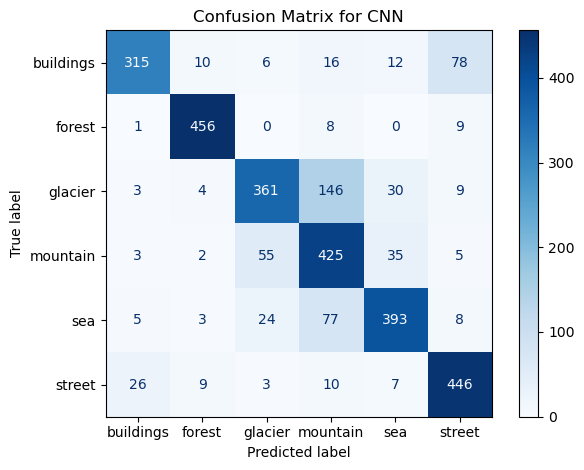

In [33]:
# Make predictions
y_pred = model.predict([test_combined_pca, test_images])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_labels_onehot, axis=1)

# Print metrics
print("Test accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred_classes, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

# Plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()